Let's visualize the MCMC concept using Matplotlib. We'll use the coin flip example (inferring the bias $\theta$ of a coin), as it's simple enough to clearly see the distributions.

**Scenario:**

*   We flipped a coin $n=20$ times and got $k=15$ heads.
*   We want to infer the probability of heads, $\theta$.
*   Our **Prior** belief about $\theta$ is a Beta distribution: $p(\theta) \sim \text{Beta}(a=2, b=2)$. This is symmetric around 0.5 but less certain than a sharp peak.
*   The **Likelihood** of observing $k$ heads in $n$ flips given $\theta$ is Binomial: $p(D|\theta) \sim \text{Binomial}(k | n, \theta)$.
*   The **Unnormalized Posterior** is $\tilde{p}(\theta) = p(D|\theta) p(\theta)$.
*   The **True Posterior** (thanks to conjugacy) is $p(\theta|D) \sim \text{Beta}(a+k, b+n-k) = \text{Beta}(2+15, 2+20-15) = \text{Beta}(17, 7)$.

We will:

1.  Plot the Prior, Likelihood (shape), and the True Posterior.
2.  Run a simple Metropolis MCMC sampler to draw samples based only on the *unnormalized* posterior.
3.  Plot the path (trace) of the MCMC sampler.
4.  Create a histogram of the MCMC samples and show how it reconstructs the True Posterior shape, effectively replacing the need to calculate the integral (normalization constant).

In [2]:
15 / 20

0.75

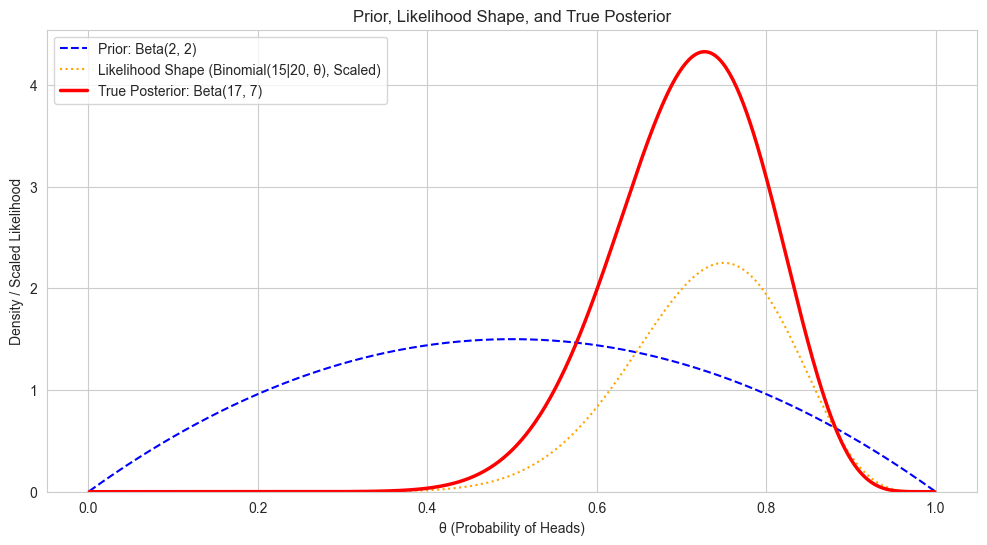

Prior suggests theta is around 0.50
Likelihood peaks at theta = 0.75
True Posterior peaks around 0.73


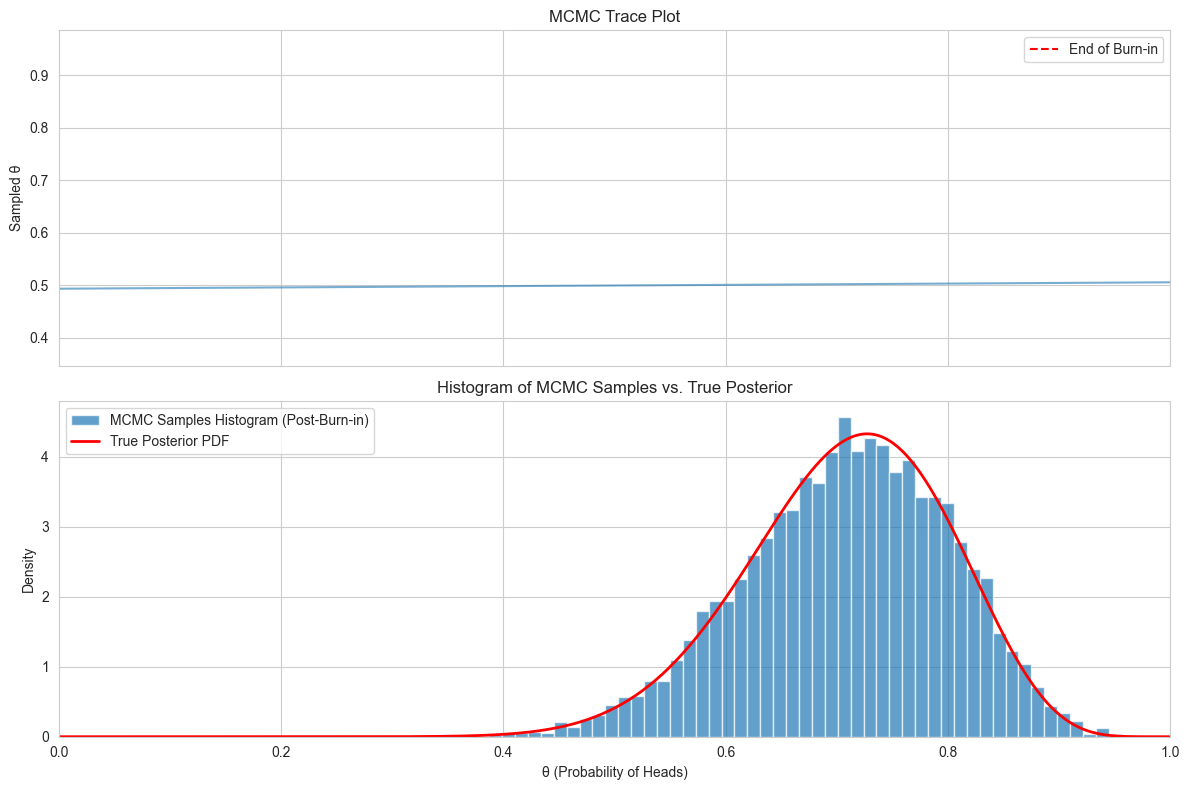


MCMC Median Estimate for theta: 0.7135
True Posterior Median:         0.7142


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Style settings
sns.set_style("whitegrid")

# --- 1. Define Model Components ---

# Data
n_trials = 20
k_successes = 15

# Prior parameters (Beta distribution)
a_prior = 2
b_prior = 2

# True Posterior parameters (Beta distribution)
a_post = a_prior + k_successes
b_post = b_prior + n_trials - k_successes

# Parameter space (theta = probability of heads)
theta_range = np.linspace(0.001, 0.999, 500)

# Calculate Prior PDF
prior_pdf = stats.beta.pdf(theta_range, a_prior, b_prior)

# Calculate Likelihood values (Binomial PMF treated as function of theta)
# Note: Binomial PMF gives probability *mass*, not density.
# We scale it visually to fit on the plot, focusing on its shape.
likelihood_vals = stats.binom.pmf(k_successes, n_trials, theta_range)
# Scale likelihood for plotting purposes (doesn't affect MCMC)
likelihood_scaled = likelihood_vals * (np.max(prior_pdf) / np.max(likelihood_vals)) * 1.5

# Calculate Unnormalized Posterior (product of prior and likelihood)
unnormalized_posterior_vals = likelihood_vals * prior_pdf
# Scale unnormalized posterior for plotting
unnormalized_posterior_scaled = unnormalized_posterior_vals * (np.max(prior_pdf) / np.max(unnormalized_posterior_vals)) * 2.0

# Calculate True Posterior PDF
true_posterior_pdf = stats.beta.pdf(theta_range, a_post, b_post)

# --- 2. Plot the Distributions ---

plt.figure(figsize=(12, 6))
plt.plot(theta_range, prior_pdf, label=f'Prior: Beta({a_prior}, {b_prior})', color='blue', linestyle='--')
plt.plot(theta_range, likelihood_scaled, label=f'Likelihood Shape (Binomial({k_successes}|{n_trials}, θ), Scaled)', color='orange', linestyle=':')
# plt.plot(theta_range, unnormalized_posterior_scaled, label='Unnormalized Posterior Shape (Scaled)', color='purple', linestyle='-.')
plt.plot(theta_range, true_posterior_pdf, label=f'True Posterior: Beta({a_post}, {b_post})', color='red', linewidth=2.5)

plt.xlabel('θ (Probability of Heads)')
plt.ylabel('Density / Scaled Likelihood')
plt.title('Prior, Likelihood Shape, and True Posterior')
plt.legend()
plt.ylim(bottom=0)
plt.show()

print(f"Prior suggests theta is around {a_prior/(a_prior+b_prior):.2f}")
print(f"Likelihood peaks at theta = {k_successes/n_trials:.2f}")
print(f"True Posterior peaks around {(a_post-1)/(a_post+b_post-2):.2f}") # Mode of Beta dist

# --- 3. Metropolis MCMC Sampler ---

def log_likelihood(theta, n, k):
    if 0 < theta < 1:
        return stats.binom.logpmf(k, n, theta)
    else:
        return -np.inf # Log(0)

def log_prior(theta, a, b):
    if 0 < theta < 1:
        return stats.beta.logpdf(theta, a, b)
    else:
        return -np.inf # Log(0)

def log_unnormalized_posterior(theta, n, k, a, b):
    lp = log_prior(theta, a, b)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, n, k)
    return lp + ll

# MCMC Settings
n_steps = 15000
n_burn = 2000
proposal_sd = 0.05 # Standard deviation for the Gaussian proposal step
theta_current = 0.5 # Starting point
samples = []

# Run MCMC
for i in range(n_steps):
    # Propose a new theta
    theta_proposal = np.random.normal(theta_current, proposal_sd)

    # Calculate log posterior for current and proposed theta
    log_p_current = log_unnormalized_posterior(theta_current, n_trials, k_successes, a_prior, b_prior)
    log_p_proposal = log_unnormalized_posterior(theta_proposal, n_trials, k_successes, a_prior, b_prior)

    # Calculate acceptance probability (log scale)
    log_acceptance_ratio = log_p_proposal - log_p_current

    # Accept or reject
    if np.log(np.random.rand()) < log_acceptance_ratio:
        # Accept
        theta_current = theta_proposal

    # Store the current sample (accepted or not)
    samples.append(theta_current)

# Discard burn-in
samples_burned = np.array(samples[n_burn:])

# --- 4. Plot MCMC Results ---

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True) # Share x-axis

# Plot 1: Trace Plot
axes[0].plot(samples, alpha=0.6)
axes[0].axvline(n_burn, linestyle='--', color='red', label='End of Burn-in')
axes[0].set_ylabel('Sampled θ')
axes[0].set_title('MCMC Trace Plot')
axes[0].legend()

# Plot 2: Histogram vs True Posterior
# Use density=True to normalize the histogram area to 1
axes[1].hist(samples_burned, bins=50, density=True, alpha=0.7, label='MCMC Samples Histogram (Post-Burn-in)')
# Plot the true posterior PDF for comparison
axes[1].plot(theta_range, true_posterior_pdf, color='red', linewidth=2, label='True Posterior PDF')
axes[1].set_xlabel('θ (Probability of Heads)')
axes[1].set_ylabel('Density')
axes[1].set_title('Histogram of MCMC Samples vs. True Posterior')
axes[1].legend()
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

# Compare mean/median from samples vs true posterior
mcmc_median = np.median(samples_burned)
true_median = stats.beta.median(a_post, b_post)
print(f"\nMCMC Median Estimate for theta: {mcmc_median:.4f}")
print(f"True Posterior Median:         {true_median:.4f}")

**Explanation of the Plots:**

1.  **First Plot (Distributions):**
    *   The **Prior** (blue dashed) shows our initial belief, centered at 0.5 but quite broad.
    *   The **Likelihood** (orange dotted, shape scaled) shows the evidence from the data. Since we observed 15 heads in 20 flips (75%), the likelihood peaks strongly at $\theta=0.75$.
    *   The **True Posterior** (solid red) shows the updated belief. It's a compromise between the prior and the likelihood, shifted towards the likelihood's peak but still influenced by the prior. It's narrower than the prior, indicating increased certainty after seeing the data. Notice its shape is determined by the *product* of the prior and likelihood shapes.

2.  **Second Plot (MCMC Trace):**
    *   This shows the value of $\theta$ sampled at each step of the MCMC run.
    *   Initially (before the red dashed line), the sampler might explore randomly as it moves away from the starting point (0.5) towards the high-probability region dictated by the posterior. This is the **burn-in** period.
    *   After burn-in, the sampler settles into exploring the region around the peak of the true posterior (around 0.7-0.75). It moves back and forth, spending more time where the posterior probability is high.

3.  **Third Plot (Histogram vs. True Posterior):**
    *   The **blue histogram** is created from the MCMC samples *after* discarding the burn-in phase. The height of each bar represents how many samples fell into that range of $\theta$.
    *   The **solid red line** is the exact, analytical True Posterior PDF we calculated earlier.
    *   **Crucially, observe how the histogram's shape closely matches the shape of the true posterior curve.** The MCMC sampler, guided only by the *unnormalized* posterior (likelihood * prior), has generated samples whose distribution matches the *normalized* posterior. The areas where the red curve is high are exactly where the histogram bars are high, meaning the sampler spent more time there.

This demonstrates the core idea: MCMC allows us to generate samples that effectively "draw" the posterior distribution for us, bypassing the need to calculate the normalization constant (the area under the unnormalized posterior curve). We approximate the integral by sampling.